# Random Walk Metropolis vs. Skipping Sampler on a non-convex domain

The following code generates and plots trajectories for the Random Walk Metropolis and for the Skipping Sampler for an ad-hoc target distribution with non-convex support defined by a set of linear and quadratic inequalities. The (logarithm of the) probability density function of the target distribution and its support are defined by two distinct functions, ```BelongsToSupport``` and ```LogTarget```. The following code has been used to generate Figure 1.

In [155]:
import time
import matplotlib.pyplot as plt
import numpy as np

def BelongsToSupport(v, a):
    """
    BelongsToSupport is a function that computes whether or not the given 2-dimensional point v belongs to 
    a specific 2-dimensional subset of the plane defined by a set of linear and quadratic inequalities.
    This is meant to be a prototypical example of the non-convex support of a conditional distribution.
    
    Parameters
    ----------
    :v: is the d-dimensional vector describing the point 
    :a: scale parameter, if increases it decreases the size of the region
    
    Returns
    ----------
    True/False depending on whether the point v belongs to the region
    """ 
    [x,y] = v
    
    return (((x+2.25*a)/1.2)**2+y**2>=1.5*a**2) and (4.75*x+y>=0.5*a or 2.7*x+y<-5.2*a or y<-3.25*a) and (x<3.2*a or x>3.65*a or y<-1.3*a or y>3.6*a) and (x<0.6*a or x>2.5*a or y<-1.75*a or y>3*a) and (x<0.1*a or x>3.2*a or y<2.7*a or y>3.6*a) and (x<-3.25*a or x>2.25*a or y<-3.6*a or y>-2.9*a) and ((x-0.5)**2+((y+0.3)/2.1)**2>=0.9*a**2) and (((x-2.65)/2.1)**2+(y+1.8)**2>=a**2)

def LogTarget(x, delta):
    """
    LogTarget returns the density of the mixture of several multivariate d-dimensional Gaussian 
    distributions evaluated at the point x.
    
    Parameters
    ----------
    :x: is the d-dimensional vector describing the point at which the density is evaluated
    :d: is the dimension of the probability space
    :NumberOfModes: is the number of Gaussian distribution in the mixture
    :ModeLocations: is the NumberOfModes x d array containing the mean of each of the NumberOfModes Gaussian distributions
    :detSigmas: is a NumberOfModes array containing the value of the determinants of the covariance matrices of the various Gaussian distributions
    :invSigmas: is a (NumberOfModes * d) x (NumberOfModes * d) matrix whose d x d diagonal blocks are the inverse of the covariance matrices of the various Gaussian distributions 
    :Weights: is the NumberOfModes array containing the weights given in the mixture to the various Gaussian distributions
    
    Note that the density does not account for the normalization constant (2 * np.pi) ** (-d/2)
    
    Returns
    ----------
    The logarithm of the the mixtured Gaussian density evaluated at the point x
    """ 
        
    return -delta*(x[1]*(2 + 3*x[1] - 2*np.abs(x[0])) + (np.abs(x[0])-1)*(-5 - 2*x[1] + 5*np.abs(x[0])))/22.0

def GenerateDirection(d, PropCovariance):
    """
    GenerateDirection returns a random direction in R^d sampled according to a multivariate zero-mean 
    Gaussian distribution and given covariance matrix.
    
    Parameters
    ----------
    :d: is the dimension of the probability space
    :PropCovariance: is the covariance matrix of the proposal distribution
        
    Returns
    ----------
    A d-dimensional vector of unit norm sampled
    """
    
    v = np.random.multivariate_normal(np.zeros(d), PropCovariance)
    return v / np.linalg.norm(v)

def GenerateDistance(d, Direction, InvCov):
    """
    GenerateDistance returns a random distance sampled from the proposal density conditionally on a given direction
    
    Parameters
    ----------
    :d: is the dimension of the probability space
    :Direction: is the d-dimensional array describing the direction
    :invCov: is the inverse of the covariance matrix of the Gaussian proposal deensity
    
    GenerateDistance assumes that the proposal density is Gaussian.
    
    Returns
    ----------
    A positive scalar descriibing the random distance
    """
    
    return (Direction.T @ InvCov @ Direction)**(-1/2) * np.sqrt(np.random.chisquare(d))


We consider a isotropic Gaussian proposal density, that we tuned using a single variance parameter ```PropVar``` so that the RWM algorithm has an average acceptance rate of 0.23688.

We consider four different starting points belonging to distinct part of the support. For each of them, we generate both a RWM and a Skipping trajectories, plot them side by side and save it in png format.


RW trajectory started at the point [0.  3.5]
Time = 2.752 sec
Average Acceptance Rate RW = 0.22015

Skipping Sampler trajectory started at the point [0.  3.5]
Time = 3.391 sec
Acceptance rate =  0.30905
Average number of skips =  5.54205
Successful skipping moves =  1396 , that is 6.98 % of the total steps.

RW trajectory started at the point [ 2. -4.]
Time = 2.528 sec
Average Acceptance Rate RW = 0.2033

Skipping Sampler trajectory started at the point [ 2. -4.]
Time = 3.761 sec
Acceptance rate =  0.31315
Average number of skips =  5.3512
Successful skipping moves =  1382 , that is 6.91 % of the total steps.

RW trajectory started at the point [-4. -4.]
Time = 2.605 sec
Average Acceptance Rate RW = 0.20865

Skipping Sampler trajectory started at the point [-4. -4.]
Time = 3.484 sec
Acceptance rate =  0.32185
Average number of skips =  5.1908
Successful skipping moves =  1402 , that is 7.01 % of the total steps.

RW trajectory started at the point [-5.  2.]
Time = 2.748 sec
Average Acc

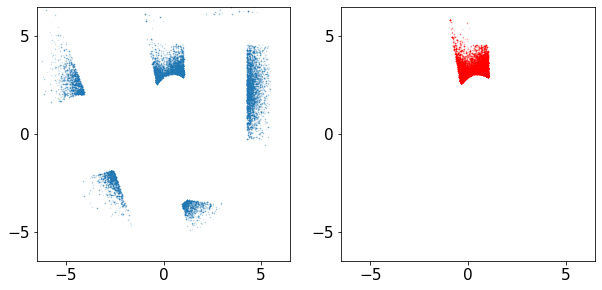

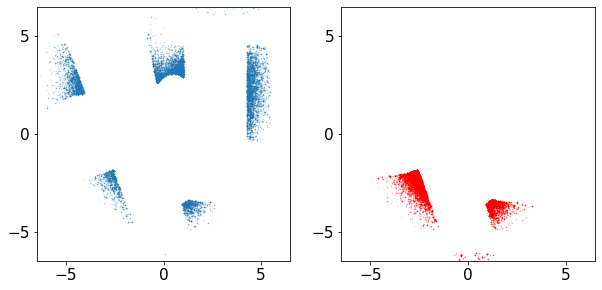

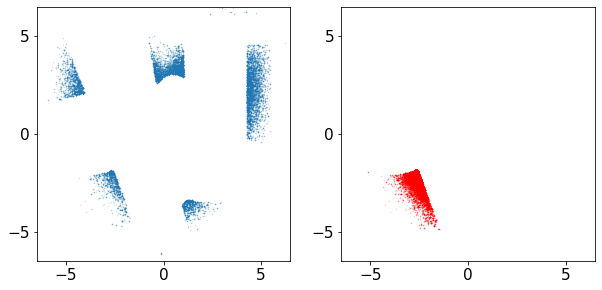

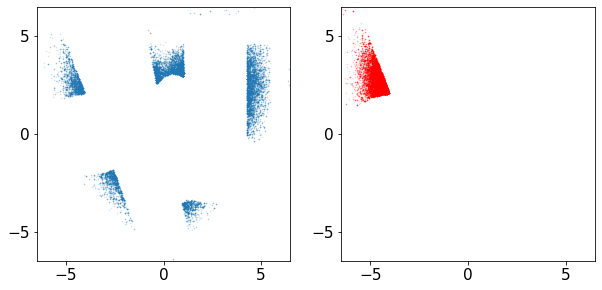

In [164]:
steps = 20000
K = 100 # Halting index is set to 100 for the Skipping Sampler

# INITIALIZATION 
d = 2 # dimension
scale = 1.7 # scale parameter of the support
delta = 2.5 # parameter of the probability density function

# PROPOSAL DENSITY (identical for RWM and Skipping Sampler)
PropVar = 0.375 # variance parameter of the proposal density, 
PropCovariance = PropVar*np.identity(d) # covariance matrix of the proposal density
InvCov = np.linalg.inv(PropCovariance) # inverse of the covariance matrix of the proposal density

# Selected starting point in different part of the support
StartingPoints = np.array([[0,3.5], [2,-4], [-4,-4], [-5,2]])

for k, InitialLocation in enumerate(StartingPoints):
    
    # RWM TRAJECTORY
    Location = InitialLocation # Initial point is taken from the collection of starting points
    print("RWM trajectory started at the point", Location)
    
    # Variable initialization
    LocationsRW = np.zeros((steps, d)) # Allocate array for the whole trajectory
    AcceptedStepsRW = np.zeros(steps, dtype=int) # Keeps track of whether a step was accepted (1) or not (0)

    # Trajectory generation 
    t = time.time()
    np.random.seed(k) # Every new RWM trajectory is given a new seed
    LogCoins = np.log(np.random.rand(steps)) # Pre-sample all accept-reject coins ahead of time

    for i in range(steps):
        LocationsRW[i] = Location # Stores previous point in the trajectory

        # Gaussian RW proposal that to mirror the Skipping Sampler routine is performed in two steps:
        # 1) sampling a direction 
        # 2) sampling a distance conditionally on the direction sampled in (1)
        Direction = GenerateDirection(d, PropCovariance) #pick a direction
        ProposedLocation = Location + GenerateDistance(d, Direction, InvCov) * Direction

        # Acceptance/rejection step
        # Points which are inside the excluded region are rejected automatically
        if LogTarget(ProposedLocation, delta) - LogTarget(Location, delta) >= LogCoins[i] and BelongsToSupport(ProposedLocation, scale):
            Location = ProposedLocation
            AcceptedStepsRW[i] = 1

    elapsed = time.time() - t
    print("Time =",np.round(elapsed,3),"sec")

    # Trajectory statistics
    AcceptanceRateRW = np.mean(AcceptedStepsRW)
    print("Average Acceptance Rate RWM =", AcceptanceRateRW)

    # Skipping Sampler TRAJECTORY
    Location = InitialLocation # Reset the initial point
    print("\nSkipping Sampler trajectory started at the point", Location)
    
    # Variable initialization
    Locations = np.zeros((steps, d)) # Allocate array for the whole trajectory
    AcceptedSteps = np.zeros(steps, dtype=int) # Keeps track of whether a step was accepted (1) or not (0)
    SkipsCounter = np.zeros(steps, dtype=int) # Keeps track of the number of skips in each skipping excursion
    SkipFlag = np.zeros(steps, dtype=int) # Keeps track of whether a move was RW (0) or a true skipping move (1)

    # Trajectory generation
    t = time.time()
    np.random.seed(k) # Every new Skipping Sampler trajectory is given the same seed as the RWM one
    LogCoins = np.log(np.random.rand(steps)) # Pre-sample all accept-reject coins ahead of time
    for i in range(steps):
        IsOutside = True # Keep tracks if the current point is outside (True) or inside (False) the support
        Locations[i] = Location # Stores previous point in the trajectory
        IntermediateLocation = Location

        Direction = GenerateDirection(d, PropCovariance) # pick a random direction

        # Keep extending the proposal by skipping in the same direction until either:
        # - the halting index is reached
        # - the proposed point belongs to the support
        while (IsOutside and SkipsCounter[i] < K):
            IntermediateLocation = IntermediateLocation + GenerateDistance(d, Direction, InvCov) * Direction;
            SkipsCounter[i] += 1 # We keep track of the number of skips in each skipping excursion
            if BelongsToSupport(IntermediateLocation, scale):
                IsOutside = False       
        ProposedLocation = IntermediateLocation

        # Acceptance/rejection step
        # Points which are outside the support are rejected automatically
        if LogTarget(ProposedLocation, delta) - LogTarget(Location, delta) >= LogCoins[i] and BelongsToSupport(IntermediateLocation, scale):
            Location = ProposedLocation
            AcceptedSteps[i] = 1
            if SkipsCounter[i]>1:
                SkipFlag[i] += 1
    elapsed = time.time() - t
    print("Time =",np.round(elapsed,3),"sec")

    # Trajectory statistics
    AcceptanceRate = np.mean(AcceptedSteps)
    AvgSkips = np.mean(SkipsCounter)
    TotalSkips = np.sum(SkipFlag)
    print("Acceptance rate = ", AcceptanceRate)
    print("Average number of skips = ", AvgSkips)
    print("Successful skipping moves = ", TotalSkips,", that is",np.round(TotalSkips/steps*100,2),"% of the total steps.\n")
    
    fontsize = 22
    markersize = 0.2
    fig = plt.figure(figsize=(10,5))
    # Skipping Sampler subplot
    plt.subplot(121)
    plt.scatter(Locations[:,0], Locations[:,1], s=markersize, alpha=0.2)
    plt.xlim(-6.5, 6.5)
    plt.ylim(-6.5, 6.5)
    plt.gca().set_aspect('equal')
    plt.xticks([-5,0,5], fontsize=0.7*fontsize)
    plt.yticks([-5,0,5], fontsize=0.7*fontsize)

    # RWM subplot
    plt.subplot(122)
    plt.scatter(LocationsRW[:,0], LocationsRW[:,1], s=markersize, alpha=0.2, color='red')
    plt.xlim(-6.5, 6.5)
    plt.ylim(-6.5, 6.5)
    plt.gca().set_aspect('equal')
    plt.xticks([-5,0,5], fontsize=0.7*fontsize)
    plt.yticks([-5,0,5], fontsize=0.7*fontsize)

    fig.savefig('RWMvsSkipping_'+str(steps)+'steps_initialpoint'+str(k)+'.png', dpi=300, bbox_inches='tight',pad_inches = 0.1)

# Appendix: tuning for RWM

In [116]:
tuning_runs = 30
steps = 10000
PropVar = 0.375

PropCovariance = PropVar*np.identity(d)
InvCov = np.linalg.inv(PropCovariance)
d = 2
a = 1.7
delta = 2.5

AverageAcceptanceRate = np.zeros(tuning_runs)

for k in range(tuning_runs):
    
    np.random.seed(k)
    
    # Sample the first point starting by skipping from the origin till the point is inside the support
    IsOutside = True
    IntermediateLocation = np.zeros(d)
    Direction = GenerateDirection(d, PropCovariance)
    while IsOutside:
        IntermediateLocation = IntermediateLocation + GenerateDistance(d, Direction, InvCov,) * Direction;
        if BelongsToSupport(IntermediateLocation, scale):
            IsOutside = False
    Location = IntermediateLocation
    
    # Variable initialization
    LocationsRW = np.zeros((steps, d)) # Allocate array for the whole trajectory
    AcceptedStepsRW = np.zeros(steps, dtype=int) # Keeps track of whether a step was accepted (1) or not (0)

    # Trajectory ggeneration 
    t = time.time()
    np.random.seed(1)
    LogCoins = np.log(np.random.rand(steps)) # Pre-sample all accept-reject coins ahead of time

    for i in range(steps):
        LocationsRW[i] = Location

        # Gaussian RW proposal that to mirror the Skipping Sampler routine is performed in two steps:
        # 1) sampling a direction 
        # 2) sampling a distance conditionally on the direction sampled in (1)
        Direction = GenerateDirection(d, PropCovariance) #pick a direction
        ProposedLocation = Location + GenerateDistance(d, Direction, InvCov) * Direction

        # Acceptance/rejection step
        # Points which are outside the target support are rejected automatically
        if LogTarget(ProposedLocation, delta) - LogTarget(Location, delta) >= LogCoins[i] and BelongsToSupport(ProposedLocation,scale):
            Location = ProposedLocation
            AcceptedStepsRW[i] = 1

    elapsed = time.time() - t
    print("Run",k," Time = ",np.round(elapsed,3),"sec")
    AverageAcceptanceRate[k] = np.mean(AcceptedStepsRW)
    
np.mean(AverageAcceptanceRate)

Run 0 Time= 1.1525189876556396
Run 1 Time= 1.27931809425354
Run 2 Time= 1.219074010848999
Run 3 Time= 1.5041420459747314
Run 4 Time= 1.2926337718963623
Run 5 Time= 1.4331598281860352
Run 6 Time= 1.2067210674285889
Run 7 Time= 1.2183575630187988
Run 8 Time= 1.2162351608276367
Run 9 Time= 1.4335029125213623
Run 10 Time= 1.5603420734405518
Run 11 Time= 1.338021993637085
Run 12 Time= 1.3778412342071533
Run 13 Time= 1.1382570266723633
Run 14 Time= 1.1505348682403564
Run 15 Time= 1.158592939376831
Run 16 Time= 1.160032033920288
Run 17 Time= 1.3782117366790771
Run 18 Time= 1.3041491508483887
Run 19 Time= 1.195439100265503
Run 20 Time= 1.1296193599700928
Run 21 Time= 1.1799960136413574
Run 22 Time= 1.1408052444458008
Run 23 Time= 1.1689729690551758
Run 24 Time= 1.1616179943084717
Run 25 Time= 1.4105851650238037
Run 26 Time= 1.1574950218200684
Run 27 Time= 1.1386339664459229
Run 28 Time= 1.1997020244598389
Run 29 Time= 1.4020709991455078


0.23688